# Assignment 4
### Do three of four.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

In [2]:
df_ames = pd.read_csv("data/ames_prices.csv")

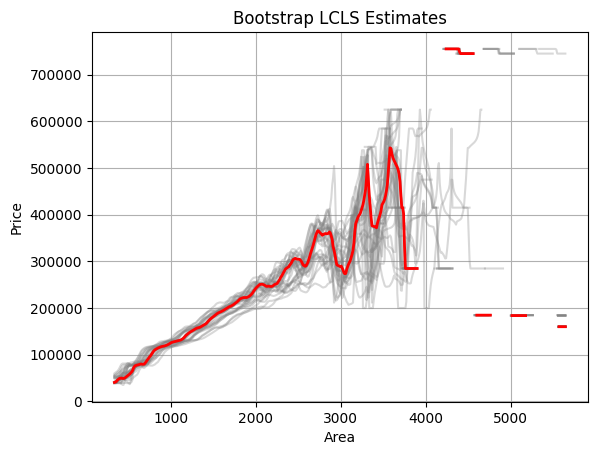

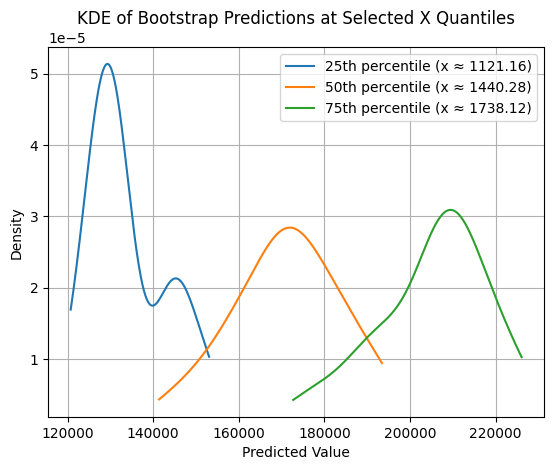

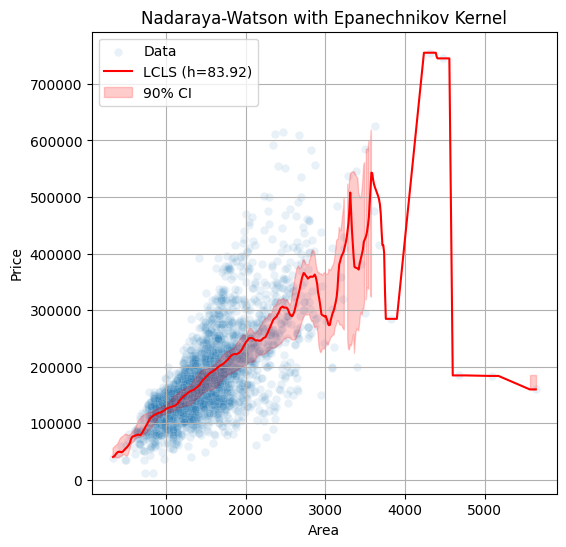

In [3]:
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")

class LCLSEstimator:
    """
    Implements the Local Constant Least Squares (Nadaraya-Watson) estimator.
    Uses the Epanechnikov kernel and plug-in bandwidth if not specified.
    """

    def __init__(self, x, y, h=None):
        self.x_name = x.name
        self.y_name = y.name

        df = pd.DataFrame({'x': x, 'y': y}).dropna()
        self.x = df['x']
        self.y = df['y']

        self.n = len(self.x)
        self.grid = np.linspace(self.x.min(), self.x.max(), 500)
        self.y_hat = None

        if h is None:
            iqr = np.quantile(self.x, 0.75) - np.quantile(self.x, 0.25)
            self.h = 0.9 * min(np.std(self.x), iqr / 1.34) * self.n ** (-1/5)
            #print(f'Computed bandwidth (Silverman\'s rule): {self.h}')
        else:
            self.h = h
            #print(f'Using provided bandwidth: {self.h}')

    def epanechnikov_kernel(self, u):
        return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

    def fit(self):
        """
        Computes the LCLS estimator using the Epanechnikov kernel.
        """
        u = (self.grid.reshape(1, -1) - self.x.to_numpy().reshape(-1, 1)) / self.h
        K = self.epanechnikov_kernel(u)

        numerator = (self.y.to_numpy().reshape(-1, 1) * K).sum(axis=0)
        denominator = K.sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            self.y_hat = np.where(denominator != 0, numerator / denominator, np.nan)

        return self.y_hat, self.grid

    def plot(self, label=None, ci=None):
        """
        Plot data and fitted curve (optionally with confidence interval).
        """
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=self.x, y=self.y, alpha=0.1, label='Data')
        sns.lineplot(x=self.grid, y=self.y_hat, color='red',
                     label=label or f'LCLS (h={self.h:.2f})')

        if ci is not None:
            lower, upper = ci
            plt.fill_between(self.grid, lower, upper, color='red', alpha=0.2, label='90% CI')

        plt.xlabel(self.x_name.capitalize())
        plt.ylabel(self.y_name.capitalize())
        plt.title('Nadaraya-Watson with Epanechnikov Kernel')
        plt.legend()
        plt.grid(True)
        plt.show()

    def bootstrap(self, n_bootstrap=30, seed=42, show_curves=True):
        """
        Perform bootstrap to estimate prediction uncertainty.
        - Returns list of y_hat curves.
        """
        np.random.seed(seed)
        bootstrap_curves = []

        for _ in range(n_bootstrap):
            idx = np.random.choice(self.n, self.n, replace=True)
            x_sample = self.x.iloc[idx].reset_index(drop=True)
            y_sample = self.y.iloc[idx].reset_index(drop=True)

            model = LCLSEstimator(x_sample, y_sample, h=self.h)
            y_hat_sample, _ = model.fit()
            bootstrap_curves.append(y_hat_sample)

            if show_curves:
                plt.plot(self.grid, y_hat_sample, color='gray', alpha=0.3)

        if show_curves:
            plt.plot(self.grid, self.y_hat, color='red', label='Original Fit', linewidth=2)
            plt.xlabel(self.x_name.capitalize())
            plt.ylabel(self.y_name.capitalize())
            plt.title('Bootstrap LCLS Estimates')
            plt.grid(True)
            plt.show()

        return np.array(bootstrap_curves)

    def kde_at_points(self, bootstrap_curves, quantiles=[0.25, 0.5, 0.75]):
        """
        For selected quantiles of X, plot KDE of bootstrapped predictions.
        """
        quantile_vals = np.quantile(self.x, quantiles)
        indices = [np.abs(self.grid - q).argmin() for q in quantile_vals]

        for i, q in zip(indices, quantiles):
            samples = bootstrap_curves[:, i]
            kde = gaussian_kde(samples)
            x_vals = np.linspace(min(samples), max(samples), 200)
            plt.plot(x_vals, kde(x_vals), label=f'{int(q*100)}th percentile (x ≈ {self.grid[i]:.2f})')

        plt.title('KDE of Bootstrap Predictions at Selected X Quantiles')
        plt.xlabel('Predicted Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_with_confidence_band(self, bootstrap_curves):
        """
        Plot the original fit along with 90% CI (5th and 95th percentiles from bootstrap).
        """
        lower = np.percentile(bootstrap_curves, 5, axis=0)
        upper = np.percentile(bootstrap_curves, 95, axis=0)
        self.plot(ci=(lower, upper))


# === USAGE ===

# Assume df2 is already defined
x = df_ames['area']
y = df_ames['price']

# Instantiate model
model = LCLSEstimator(x, y)
model.fit()

# Bootstrap
bootstrap_curves = model.bootstrap(n_bootstrap=30)

# KDE at 25%, 50%, 75% quantiles of X
model.kde_at_points(bootstrap_curves)

# Plot with 90% confidence interval
model.plot_with_confidence_band(bootstrap_curves)


Plot 1: Bootstrap LCLS Estimates

The spread of gray lines around the red line reflects uncertainty in the model’s predictions.

For smaller area values, the fits are tighter and more consistent.

For larger area values (especially beyond ~3500), the fits become erratic due to sparse data, leading to high variability.

Plot 2: KDE of Bootstrap Predictions at Selected X Quantiles

Distributions are smooth and unimodal at each quantile.

Spread decreases slightly as Area increases, suggesting slightly higher model stability in the mid-range.

Provides insight into prediction uncertainty at specific points along the Area axis.

Plot 3: Nadaraya-Watson with Epanechnikov Kernel and 90% Confidence Interval

The CI band is narrowest in the mid-range of the data where the density of points is highest.

CI widens at the tails, especially beyond Area > 3500, reflecting model uncertainty due to data sparsity.

The model appears to capture the main trend in the data but behaves erratically in sparse regions.